In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
plt.rcParams['font.sans-serif'] = ['SimHei']        # 设置中文字体为黑体
plt.rcParams['axes.unicode_minus'] = False    

In [2]:
df = pd.read_csv("C:/Users/Administrator/Desktop/Metro_Interstate_Traffic_Volume.csv",
                 encoding="gbk",
                 index_col='date_time',
                 parse_dates=['date_time']).reset_index()
df['holiday'] = df['holiday'].notna().astype(int)
df['日期']  = df['date_time'].dt.day
df["小时"] = df["date_time"].dt.hour
df.head()

,date_time,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,traffic_volume,日期,小时
0,2012-10-02 09:00:00,0,288.28,0.0,0.0,40,Clouds,scattered clouds,5545,2,9
1,2012-10-02 10:00:00,0,289.36,0.0,0.0,75,Clouds,broken clouds,4516,2,10
2,2012-10-02 11:00:00,0,289.58,0.0,0.0,90,Clouds,overcast clouds,4767,2,11
3,2012-10-02 12:00:00,0,290.13,0.0,0.0,90,Clouds,overcast clouds,5026,2,12
4,2012-10-02 13:00:00,0,291.14,0.0,0.0,75,Clouds,broken clouds,4918,2,13


In [3]:
hourly_avg = df.groupby('小时')['traffic_volume'].mean()
threshold = hourly_avg.mean() + hourly_avg.std()
df['是否为高峰'] = df['traffic_volume'] > threshold.astype(int)
df['是否为高峰'] = df['是否为高峰'].astype(int)
df['temp_celsius'] = df['temp'] - 273.15
df['temp_celsius'] = df['temp_celsius'].round(2)
df['weekday'] = df['date_time'].dt.weekday  # 0=周一
df['is_weekend'] = df['weekday'].apply(lambda x: 1 if x >= 5 else 0)
df['weather_main_code'] = df['weather_main'].astype('category').cat.codes

df.head()

,date_time,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,traffic_volume,日期,小时,是否为高峰,temp_celsius,weekday,is_weekend,weather_main_code
0,2012-10-02 09:00:00,0,288.28,0.0,0.0,40,Clouds,scattered clouds,5545,2,9,1,15.13,1,0,1
1,2012-10-02 10:00:00,0,289.36,0.0,0.0,75,Clouds,broken clouds,4516,2,10,0,16.21,1,0,1
2,2012-10-02 11:00:00,0,289.58,0.0,0.0,90,Clouds,overcast clouds,4767,2,11,0,16.43,1,0,1
3,2012-10-02 12:00:00,0,290.13,0.0,0.0,90,Clouds,overcast clouds,5026,2,12,0,16.98,1,0,1
4,2012-10-02 13:00:00,0,291.14,0.0,0.0,75,Clouds,broken clouds,4918,2,13,0,17.99,1,0,1


In [4]:
df.to_csv("处理后的_Metro_Interstate_Traffic_Volume.csv", index=False, encoding='utf-8-sig')

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
feature_cols = [
    '小时', 'weekday', 'is_weekend', 'holiday',
    'temp_celsius', 'rain_1h', 'snow_1h', 'clouds_all',
    'weather_main_code', '是否为高峰'
]
target_col = 'traffic_volume'


In [6]:
X = df[feature_cols]
y = df[target_col]


# 划分训练集和测试集（80%训练，20%测试）
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
y_train_aug = y_train + np.random.normal(0, 100, size=len(y_train))

In [7]:
# 建立线性回归模型
lr = LinearRegression()
lr.fit(X_train, y_train)

# 预测
y_pred_lr = lr.predict(X_test)

# 评估
print("📊 线性回归模型评估：")
print(f"MSE:  {mean_squared_error(y_test, y_pred_lr):,.2f}")
print(f"MAE:  {mean_absolute_error(y_test, y_pred_lr):,.2f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_lr)) :,.2f}")
print(f"R²:   {r2_score(y_test, y_pred_lr):.4f}")


📊 线性回归模型评估：
MSE:  1,646,088.73
MAE:  1,082.19
RMSE: 1,283.00
R²:   0.5836


In [8]:
rf = RandomForestRegressor(n_estimators=150, random_state=42)
rf.fit(X_train, y_train_aug)
y_pred_rf = rf.predict(X_test)

print("\n🌲 随机森林模型评估：")
print(f"MSE:  {mean_squared_error(y_test, y_pred_rf):,.2f}")
print(f"MAE:  {mean_absolute_error(y_test, y_pred_rf):,.2f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_rf)) :,.2f}")
print(f"R²:   {r2_score(y_test, y_pred_rf):.4f}")


🌲 随机森林模型评估：
MSE:  140,165.05
MAE:  231.25
RMSE: 374.39
R²:   0.9645


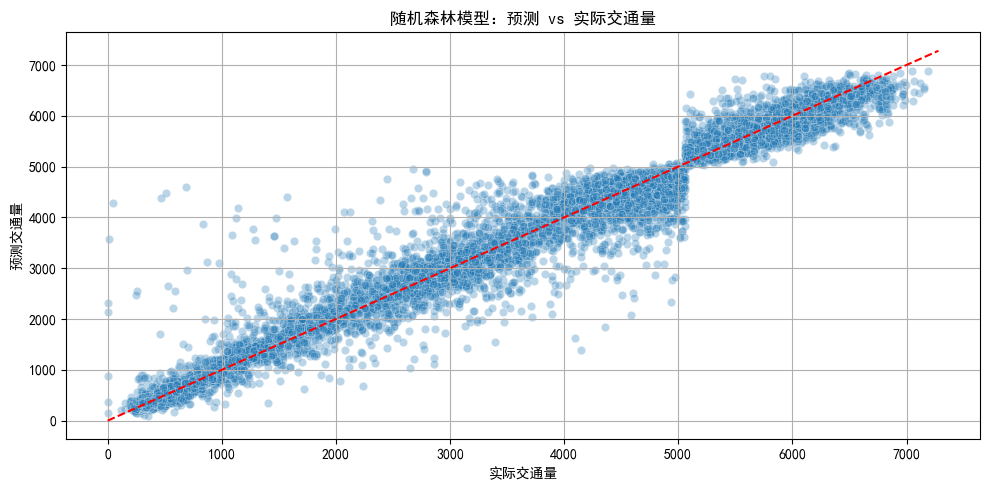

In [9]:
plt.figure(figsize=(10, 5))
sns.scatterplot(x=y_test, y=y_pred_rf, alpha=0.3)
plt.plot([y.min(), y.max()], [y.min(), y.max()], '--', color='red')
plt.xlabel("实际交通量")
plt.ylabel("预测交通量")
plt.title("随机森林模型：预测 vs 实际交通量")
plt.grid(True)
plt.tight_layout()
plt.show()


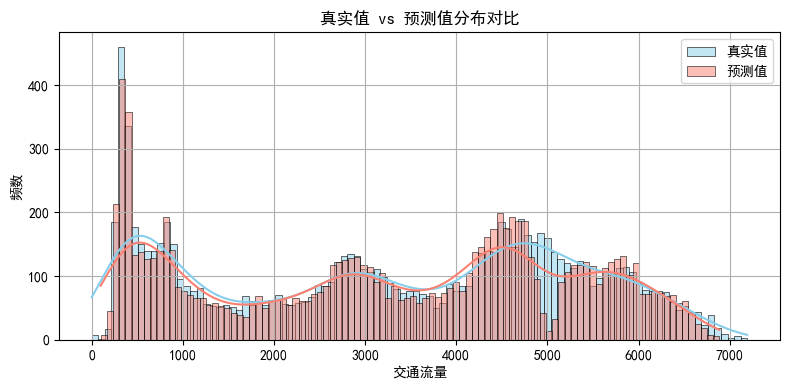

In [10]:
plt.figure(figsize=(8, 4))
sns.histplot(y_test, bins=100, kde=True, color='skyblue', label='真实值')
sns.histplot(y_pred_rf, bins=100, kde=True, color='salmon', label='预测值', alpha=0.5)
plt.legend()
plt.title("真实值 vs 预测值分布对比")
plt.xlabel("交通流量")
plt.ylabel("频数")
plt.grid(True)
plt.tight_layout()
plt.show()


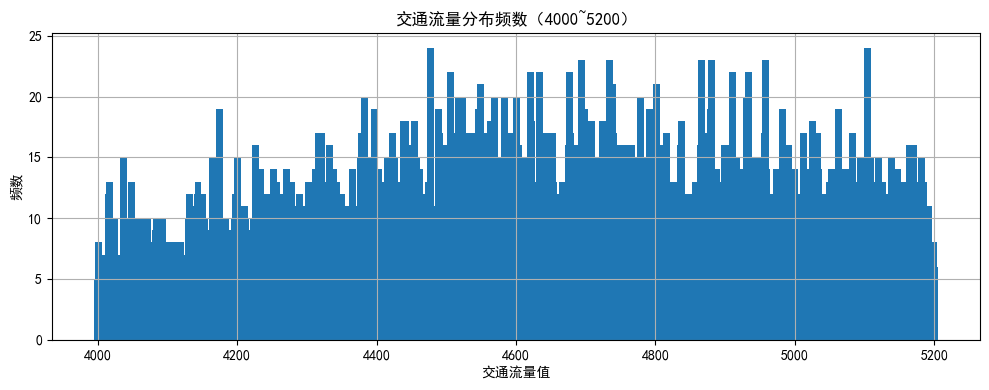

In [11]:
# 统计 traffic_volume 的精确频率
traffic_counts = df['traffic_volume'].value_counts().sort_index()
traffic_counts
import matplotlib.pyplot as plt

sub_counts = traffic_counts.loc[4000:5200]

plt.figure(figsize=(10, 4))
plt.bar(sub_counts.index, sub_counts.values, width=10)
plt.title("交通流量分布频数（4000~5200）")
plt.xlabel("交通流量值")
plt.ylabel("频数")
plt.grid(True)
plt.tight_layout()
plt.show()



In [12]:
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
mlp = MLPRegressor(
    hidden_layer_sizes=(128, 64, 32),
    activation='relu',
    solver='adam',
    max_iter=500,
    early_stopping=True,
    random_state=42
)
mlp.fit(X_train_scaled, y_train)
y_pred = mlp.predict(X_test_scaled)


In [13]:

print(f"MSE:  {mean_squared_error(y_test, y_pred):,.2f}")
print(f"MAE:  {mean_absolute_error(y_test, y_pred):,.2f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)) :,.2f}")
print(f"R²:   {r2_score(y_test, y_pred):.4f}")

MSE:  187,939.10
MAE:  280.81
RMSE: 433.52
R²:   0.9525


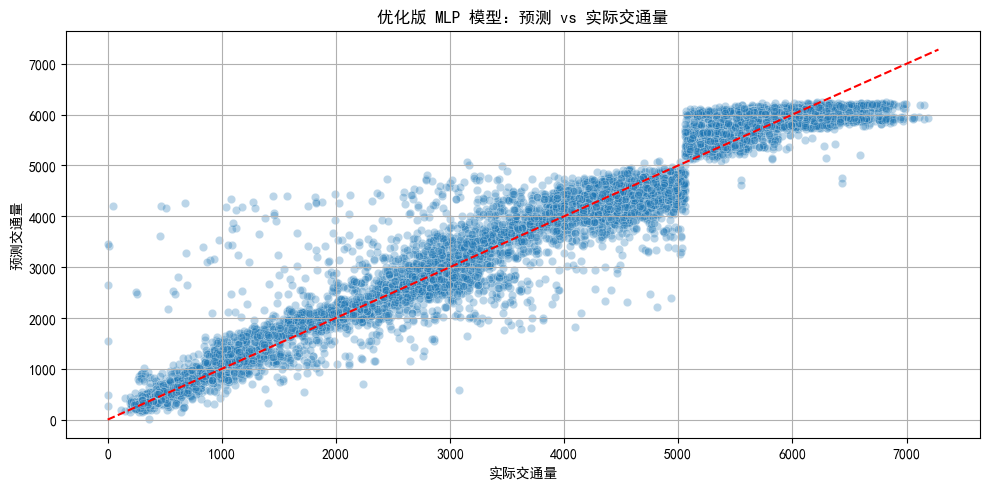

In [14]:
plt.figure(figsize=(10, 5))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.3)
plt.plot([y.min(), y.max()], [y.min(), y.max()], '--', color='red')
plt.xlabel("实际交通量")
plt.ylabel("预测交通量")
plt.title("优化版 MLP 模型：预测 vs 实际交通量")
plt.grid(True)
plt.tight_layout()
plt.show()

In [15]:
mlp = MLPRegressor(
    hidden_layer_sizes=(256, 128, 64, 32),  # 多层神经元
    activation='relu',
    solver='adam',
    alpha=0.001, 
    max_iter=1000,
    early_stopping=True,
    random_state=42
)

mlp.fit(X_train_scaled, y_train)
y_pred = mlp.predict(X_test_scaled)

# 4. 模型评估
print("MSE:", mean_squared_error(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("R2:", r2_score(y_test, y_pred))


MSE: 163904.26860642934
MAE: 254.3487575586628
RMSE: 404.85092145928155
R2: 0.9585421255910632


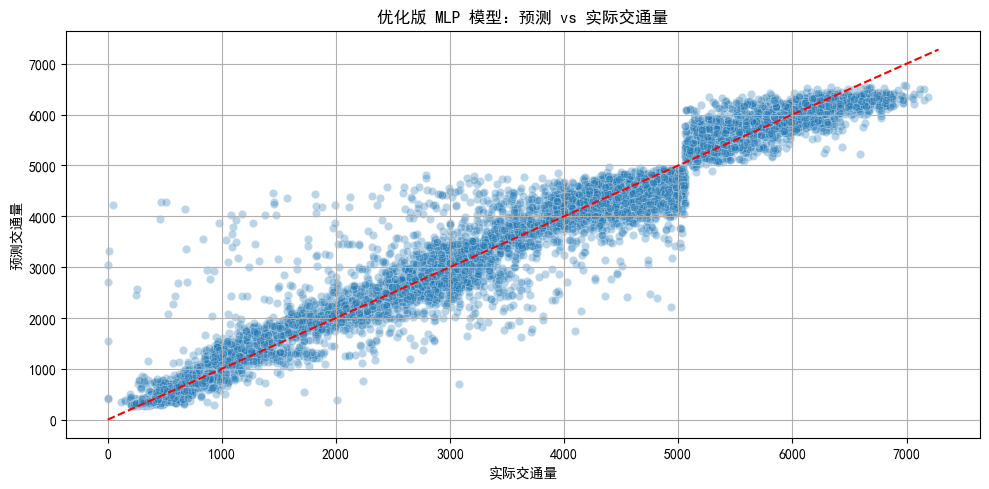

In [16]:
plt.figure(figsize=(10, 5))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.3)
plt.plot([y.min(), y.max()], [y.min(), y.max()], '--', color='red')
plt.xlabel("实际交通量")
plt.ylabel("预测交通量")
plt.title("优化版 MLP 模型：预测 vs 实际交通量")
plt.grid(True)
plt.tight_layout()
plt.show()

In [17]:
# 1. 按交通量分为 7 档：0~1000，1000~2000，...，6000~7500
bins = [0, 1000, 2000, 3000, 4000, 5000, 6000, 7500]  # 分段边界
labels = [0, 1, 2, 3, 4, 5, 6]  # 每段的编号

# cut()：将 traffic_volume 按照区间进行分档，转换为等级标签
df['volume_level'] = pd.cut(df['traffic_volume'], bins=bins, labels=labels)

# 映射等级编号 → 各区间中间值（用于回归评估）
level_to_center = {
    0: 500, 1: 1500, 2: 2500, 3: 3500, 4: 4500, 5: 5500, 6: 6500
}
df = df.dropna(subset=['volume_level'])
print(df[['traffic_volume', 'volume_level']].head(10))


   traffic_volume volume_level
0            5545            5
1            4516            4
2            4767            4
3            5026            5
4            4918            4
5            5181            5
6            5584            5
7            6015            6
8            5791            5
9            4770            4


In [27]:
from sklearn.neural_network import MLPClassifier
X = df[feature_cols]
y = df['volume_level'].astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
mlp_cls = MLPClassifier(hidden_layer_sizes=(128, 64), max_iter=500, early_stopping=True, random_state=42)
mlp_cls.fit(X_train_scaled, y_train)
y_pred_cls = mlp_cls.predict(X_test_scaled)
print("预测前 10 个等级：", y_pred_cls[:10])
print("对应真实等级：", np.array(y_test)[:10])

预测前 10 个等级： [3 1 5 3 3 3 2 4 5 0]
对应真实等级： [3 1 5 3 3 3 2 4 6 0]


In [28]:
from sklearn.metrics import classification_report, confusion_matrix

print("分类报告：")
print(classification_report(y_test, y_pred_cls))

print("混淆矩阵：")
print(confusion_matrix(y_test, y_pred_cls))


分类报告：
              precision    recall  f1-score   support

           0       0.96      0.95      0.95      2156
           1       0.75      0.77      0.76       891
           2       0.72      0.71      0.71      1248
           3       0.66      0.55      0.60      1118
           4       0.80      0.93      0.86      1944
           5       0.86      0.84      0.85      1554
           6       0.80      0.72      0.76       730

    accuracy                           0.82      9641
   macro avg       0.79      0.78      0.78      9641
weighted avg       0.81      0.82      0.81      9641

混淆矩阵：
[[2038   98   11    0    9    0    0]
 [  79  685   94   11   22    0    0]
 [   2  120  883  193   50    0    0]
 [   1   12  217  616  272    0    0]
 [   0    1   23  112 1808    0    0]
 [   0    1    2    2  112 1310  127]
 [   0    0    0    0    0  206  524]]


C:\Users\Administrator\AppData\Local\Temp\ipykernel_14980\1161546498.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_pred_cls, palette="Blues", label="预测值")
C:\Users\Administrator\AppData\Local\Temp\ipykernel_14980\1161546498.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_test, palette="Reds", alpha=0.5, label="实际值")


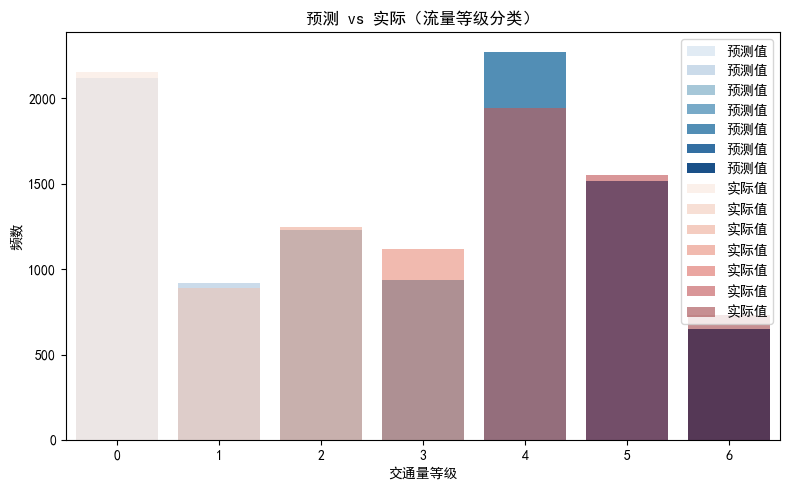

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.countplot(x=y_pred_cls, palette="Blues", label="预测值")
sns.countplot(x=y_test, palette="Reds", alpha=0.5, label="实际值")
plt.title("预测 vs 实际（流量等级分类）")
plt.xlabel("交通量等级")
plt.ylabel("频数")
plt.legend()
plt.tight_layout()
plt.show()


In [30]:
pred_volume = [level_to_center[level] for level in y_pred_cls]
test_volume = [level_to_center[level] for level in y_test]
print("回归映射评估：")
print("MSE:", mean_squared_error(test_volume, pred_volume))
print("MAE:", mean_absolute_error(test_volume, pred_volume))
print("RMSE:", np.sqrt(mean_squared_error(test_volume, pred_volume)))
print("R2:", r2_score(test_volume, pred_volume))

回归映射评估：
MSE: 255990.04252670886
MAE: 204.33564982885594
RMSE: 505.954585438959
R2: 0.9357594376828569


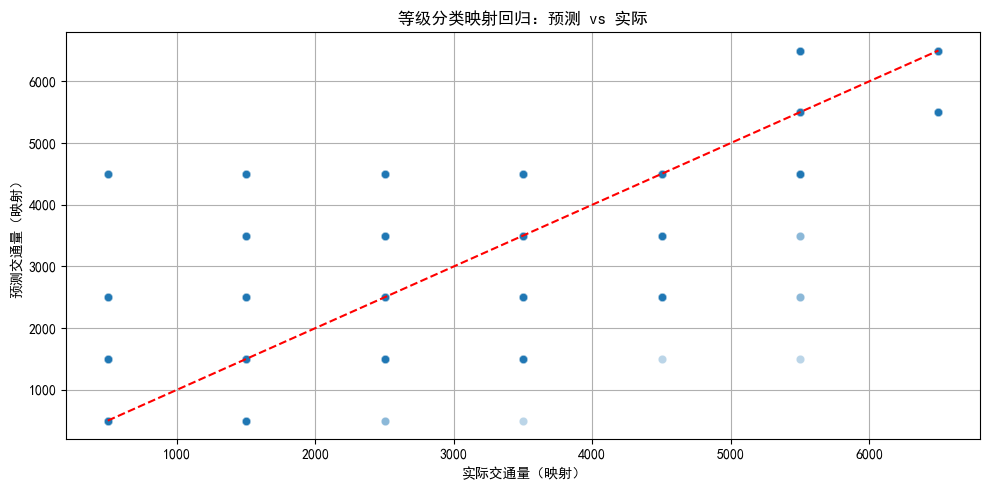

In [31]:
plt.figure(figsize=(10, 5))
sns.scatterplot(x=test_volume, y=pred_volume, alpha=0.3)
plt.plot([min(test_volume), max(test_volume)], [min(test_volume), max(test_volume)], '--', color='red')
plt.xlabel("实际交通量（映射）")
plt.ylabel("预测交通量（映射）")
plt.title("等级分类映射回归：预测 vs 实际")
plt.grid(True)
plt.tight_layout()
plt.show()


In [32]:
y_raw = df['traffic_volume']        # 原始目标变量
y = np.log1p(y_raw)                 # 平滑处理：log1p = log(1 + x)

# 观察对比
print("原始范围：", y_raw.min(), "→", y_raw.max())
print("log1p后：", y.min(), "→", y.max())


原始范围： 1 → 7280
log1p后： 0.6931471805599453 → 8.893023494394711


In [33]:
# 添加正态扰动，均值为0，标准差为0.1（建议范围 0.05~0.2）
np.random.seed(42)
y_aug = y + np.random.normal(loc=0, scale=0.1, size=len(y))

# 查看扰动后数据
print("扰动前 y（前10个）：", y[:10].values)
print("扰动后 y_aug（前10个）：", y_aug[:10])


扰动前 y（前10个）： [8.62083223 8.41560334 8.46968221 8.52257866 8.50086054 8.55294636
 8.62783971 8.70217787 8.66423293 8.47031121]
扰动后 y_aug（前10个）： 0    8.670504
1    8.401777
2    8.534451
3    8.674882
4    8.477445
5    8.529533
6    8.785761
7    8.778921
8    8.617285
9    8.524567
Name: traffic_volume, dtype: float64


In [38]:
X = df[feature_cols]
X_train, X_test, y_train, y_test = train_test_split(X, y_aug, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [39]:
mlp = MLPRegressor(
    hidden_layer_sizes=(256, 128, 64),
    activation='relu',
    solver='adam',
    max_iter=1000,
    early_stopping=True,
    random_state=42
)

# 模型训练
mlp.fit(X_train_scaled, y_train)

MLPRegressor(early_stopping=True, hidden_layer_sizes=(256, 128, 64),
             max_iter=1000, random_state=42)

C:\Users\Administrator\AppData\Local\Temp\ipykernel_14980\2518476283.py:5: RuntimeWarning: overflow encountered in expm1
  y_pred = np.expm1(y_pred_log)


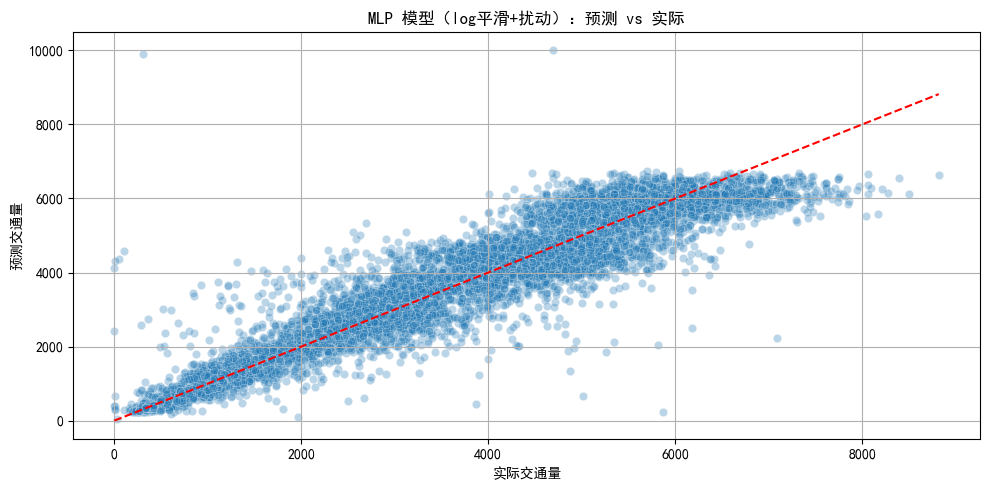

In [65]:
y_pred_log = mlp.predict(X_test_scaled)


y_true = np.expm1(y_test)      
y_pred = np.expm1(y_pred_log)
y_pred = np.clip(y_pred, 0, 10000)  # 限制最大为 10000

# 3. 画图
plt.figure(figsize=(10, 5))
sns.scatterplot(x=y_true, y=y_pred, alpha=0.3)
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], '--', color='red')
plt.xlabel("实际交通量")
plt.ylabel("预测交通量")
plt.title("MLP 模型（log平滑+扰动）：预测 vs 实际")
plt.grid(True)
plt.tight_layout()
plt.show()

In [66]:
print("y_true 中是否有无穷大：", np.isinf(y_true).any())
print("y_pred 中是否有无穷大：", np.isinf(y_pred).any())

print("y_true 中是否有 NaN：", np.isnan(y_true).any())
print("y_pred 中是否有 NaN：", np.isnan(y_pred).any())


y_true 中是否有无穷大： False
y_pred 中是否有无穷大： False
y_true 中是否有 NaN： False
y_pred 中是否有 NaN： False


In [67]:
print("R2:", r2_score(y_true, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_true, y_pred)))
print("MAE:", mean_absolute_error(y_true, y_pred))

R2: 0.911293717175385
RMSE: 604.4345378089465
MAE: 407.1145596965177
